In [36]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import squarify

In [37]:
dataset = pd.read_excel('Dataset.xlsx')
return_table = pd.read_excel('Dataset.xlsx', sheet_name = 4)
segmentation = pd.read_excel('Dataset.xlsx', sheet_name = 5)
segmentation

,Segment,RFM Score
0,Champions,"555, 554, 544, 545, 454, 455, 445"
1,Loyal,"543, 444, 435, 355, 354, 345, 344, 335"
2,Potential Loyalist,"553, 551, 552, 541, 542, 533, 532, 531, 452, 4..."
3,New Customers,"512, 511, 422, 421, 412, 411, 311"
4,Promising,"525, 524, 523, 522, 521, 515, 514, 513, 425,42..."
5,Need Attention,"535, 534, 443, 434, 343, 334, 325, 324"
6,About To Sleep,"331, 321, 312, 221, 213, 231, 241, 251"
7,At Risk,"255, 254, 245, 244, 253, 252, 243, 242, 235, 2..."
8,Cannot Lose Them,"155, 154, 144, 214,215,115, 114, 113"
9,Hibernating customers,"332, 322, 233, 232, 223, 222, 132, 123, 122, 2..."


In [20]:
# convert comma-separated string to a list of rfm scores

segmentation['RFM Score'] = segmentation['RFM Score'].str.split(',')
segmentation = segmentation.explode('RFM Score').reset_index(drop=True)
segmentation['RFM Score']= segmentation['RFM Score'].astype(int)
segmentation.sort_values(by='RFM Score')
segmentation

,Segment,RFM Score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
...,...,...
120,Lost customers,112
121,Lost customers,121
122,Lost customers,131
123,Lost customers,141


In [21]:
#merge left only
data = pd.merge(dataset, return_table, on=['Order ID'], how="outer", indicator=True)
data = data[data['_merge'] == 'left_only']


In [22]:
#Group customers by latest purchase date
GR = data.groupby(['Customer ID'])['Order Date'].max().reset_index()
GR = GR.sort_values('Order Date', ascending=False)
#Ngu phan vi chi so R
R_labels = ['1', '2', '3', '4', '5']
GR['Recency'] = pd.qcut(GR['Order Date'], q=5, labels = R_labels)
# R = GR.drop('Order Date', axis='columns')
GR

,Customer ID,Order Date,Recency
391,JM-15580,2017-12-30,5
602,PO-18865,2017-12-30,5
132,CC-12430,2017-12-30,5
101,BP-11185,2017-12-29,5
428,KH-16360,2017-12-29,5
...,...,...,...
636,RE-19405,2014-12-29,1
309,GR-14560,2014-11-21,1
551,NB-18580,2014-10-22,1
167,CR-12625,2014-08-23,1


In [23]:
today = datetime.datetime.strptime('2017-12-31', '%Y-%m-%d')
GR['recency_day'] = (today - GR['Order Date']).dt.days
GR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791 entries, 391 to 546
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Customer ID  791 non-null    object        
 1   Order Date   791 non-null    datetime64[ns]
 2   Recency      791 non-null    category      
 3   recency_day  791 non-null    int64         
dtypes: category(1), datetime64[ns](1), int64(1), object(1)
memory usage: 25.7+ KB


In [24]:
#caculate Frequency
GF = data.groupby(['Customer ID'])['Order ID'].nunique().reset_index()
GF = GF.sort_values('Order ID', ascending=False)
F_labels = ['1', '2', '3', '4', '5']
GF['Frequency'] = pd.qcut(GF['Order ID'], q=5, labels = F_labels)
GF

,Customer ID,Order ID,Frequency
275,EP-13915,17,5
147,CK-12205,13,5
700,SM-20950,12,5
423,KD-16495,12,5
355,JE-15745,12,5
...,...,...,...
546,MW-18235,1,1
301,GH-14665,1,1
344,JC-15385,1,1
49,AR-10570,1,1


In [25]:
#caculate Monetary
GM = data.groupby(['Customer ID'])['Sales'].sum().reset_index()
GM = GM.sort_values('Sales', ascending=False)
M_labels = ['1', '2', '3', '4', '5']
GM['Monetary'] = pd.qcut(GM['Sales'], q=5, labels = M_labels)
GM

,Customer ID,Sales,Monetary
698,SM-20320,24516.600,5
739,TC-20980,18951.820,5
728,TA-21385,14595.620,5
433,KL-16645,14175.229,5
6,AB-10105,13881.263,5
...,...,...,...
657,RS-19870,22.328,1
507,MG-18205,16.739,1
145,CJ-11875,16.520,1
455,LD-16855,5.304,1


In [26]:
#caculate RFM score
RFM_table = pd.concat([GR, GF, GM]).groupby(['Customer ID'], as_index=False).first()
RFM_table = RFM_table.sort_values(['Recency', 'Frequency', 'Monetary'], ascending = [False, False, False])
RFM_table['RFM Score'] = RFM_table[["Recency", "Frequency", "Monetary"]].apply("".join, axis=1)
RFM_table['RFM Score'] = RFM_table['RFM Score'].astype(int)
RFM_table


,Customer ID,Order Date,Recency,recency_day,Order ID,Frequency,Sales,Monetary,RFM Score
31,AH-10210,2017-12-24,5,7.0,9.0,5,4805.3440,5,555
35,AI-10855,2017-12-17,5,14.0,10.0,5,4375.7860,5,555
82,BF-11170,2017-12-14,5,17.0,11.0,5,5907.9720,5,555
215,DK-13225,2017-12-20,5,11.0,9.0,5,4802.3940,5,555
275,EP-13915,2017-12-18,5,13.0,17.0,5,5478.0608,5,555
...,...,...,...,...,...,...,...,...,...
713,SS-20515,2016-08-26,1,492.0,3.0,1,613.4000,1,111
726,SW-20755,2016-07-14,1,535.0,1.0,1,663.9640,1,111
758,TS-21085,2017-01-07,1,358.0,2.0,1,4.8330,1,111
759,TS-21160,2016-08-13,1,505.0,4.0,1,552.8160,1,111


In [27]:
#customer segmentation grouping
RFM_Segment = RFM_table.merge(segmentation, how='left', on='RFM Score')
RFM_Segment.columns = RFM_Segment.columns.str.replace('Order ID', 'order quantity')
RFM_Segment

,Customer ID,Order Date,Recency,recency_day,order quantity,Frequency,Sales,Monetary,RFM Score,Segment
0,AH-10210,2017-12-24,5,7.0,9.0,5,4805.3440,5,555,Champions
1,AI-10855,2017-12-17,5,14.0,10.0,5,4375.7860,5,555,Champions
2,BF-11170,2017-12-14,5,17.0,11.0,5,5907.9720,5,555,Champions
3,DK-13225,2017-12-20,5,11.0,9.0,5,4802.3940,5,555,Champions
4,EP-13915,2017-12-18,5,13.0,17.0,5,5478.0608,5,555,Champions
...,...,...,...,...,...,...,...,...,...,...
786,SS-20515,2016-08-26,1,492.0,3.0,1,613.4000,1,111,Lost customers
787,SW-20755,2016-07-14,1,535.0,1.0,1,663.9640,1,111,Lost customers
788,TS-21085,2017-01-07,1,358.0,2.0,1,4.8330,1,111,Lost customers
789,TS-21160,2016-08-13,1,505.0,4.0,1,552.8160,1,111,Lost customers


In [28]:
#Customer value
Segment_cus = RFM_Segment.groupby(['Segment'])['Customer ID'].count().reset_index()
Segment_cus
Segment_cus = RFM_Segment.groupby('Segment').agg({'Customer ID': 'count',
                                     'Sales': 'sum',
                                     'recency_day': 'mean'}).reset_index()
Segment_cus.columns = ['segment', 'cus_count', 'total_monetary', 'avg_recency']
Segment_cus.sort_values(by='cus_count', ascending=False, inplace=True)
Segment_cus

,segment,cus_count,total_monetary,avg_recency
9,Potential Loyalist,111,188078.1563,44.468468
1,At Risk,96,385996.8861,259.041667
4,Hibernating customers,93,113882.7190,186.946237
5,Lost customers,83,54264.2255,557.963855
7,Need Attention,76,268450.6204,49.407895
3,Champions,69,376042.6898,28.086957
6,Loyal,61,270352.5752,61.721311
10,Promising,61,221333.1925,34.983607
8,New Customers,60,39806.5270,40.716667
0,About To Sleep,44,46468.5372,129.386364


C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\3871461108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(RFM_Segment[col])


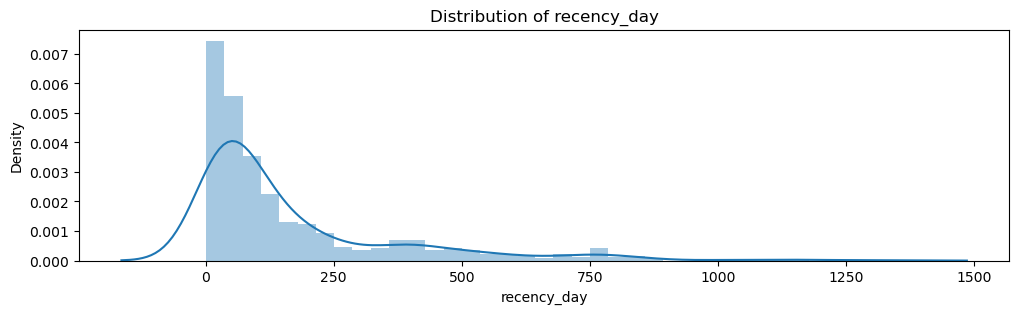

C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\3871461108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(RFM_Segment[col])


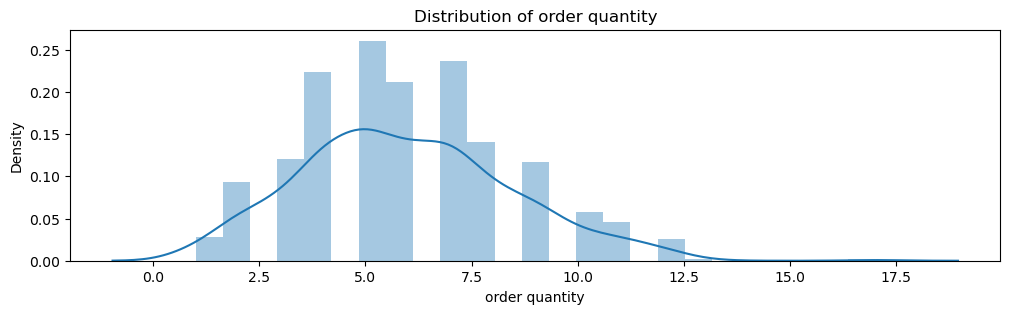

C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\3871461108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(RFM_Segment[col])


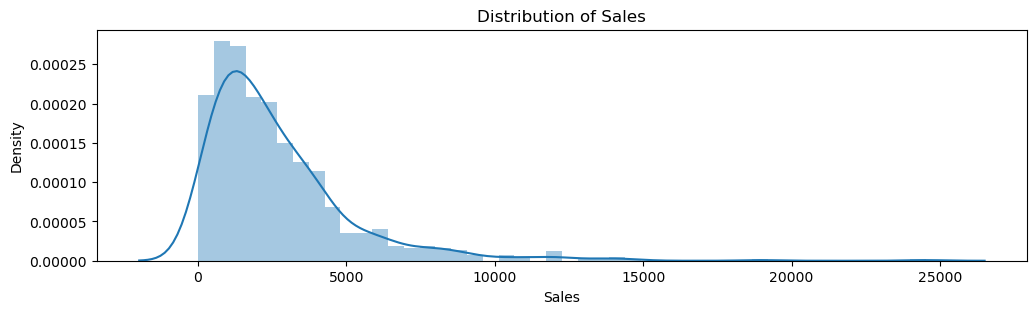

In [33]:
# show distribution of each variable of the model

colnames = ['recency_day', 'order quantity', 'Sales']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(RFM_Segment[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

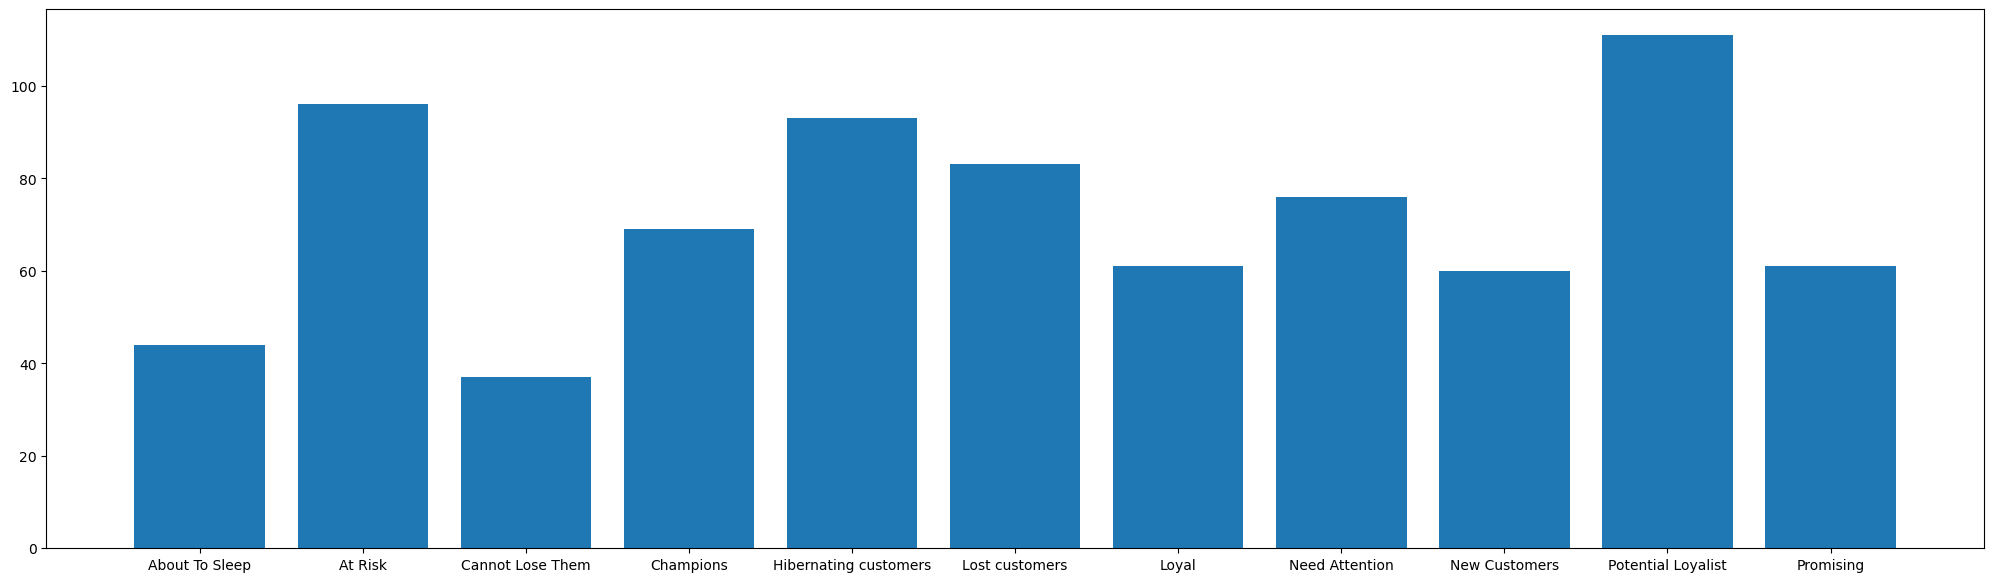

In [15]:
# number of customers of each segment
Segment_customer = RFM_Segment.groupby(['Segment'])['Customer ID'].count().reset_index()
fig = plt.figure(figsize = (25, 7))
plt.bar(Segment_customer['Segment'], Segment_customer['Customer ID'], width = 0.8)
plt.show()

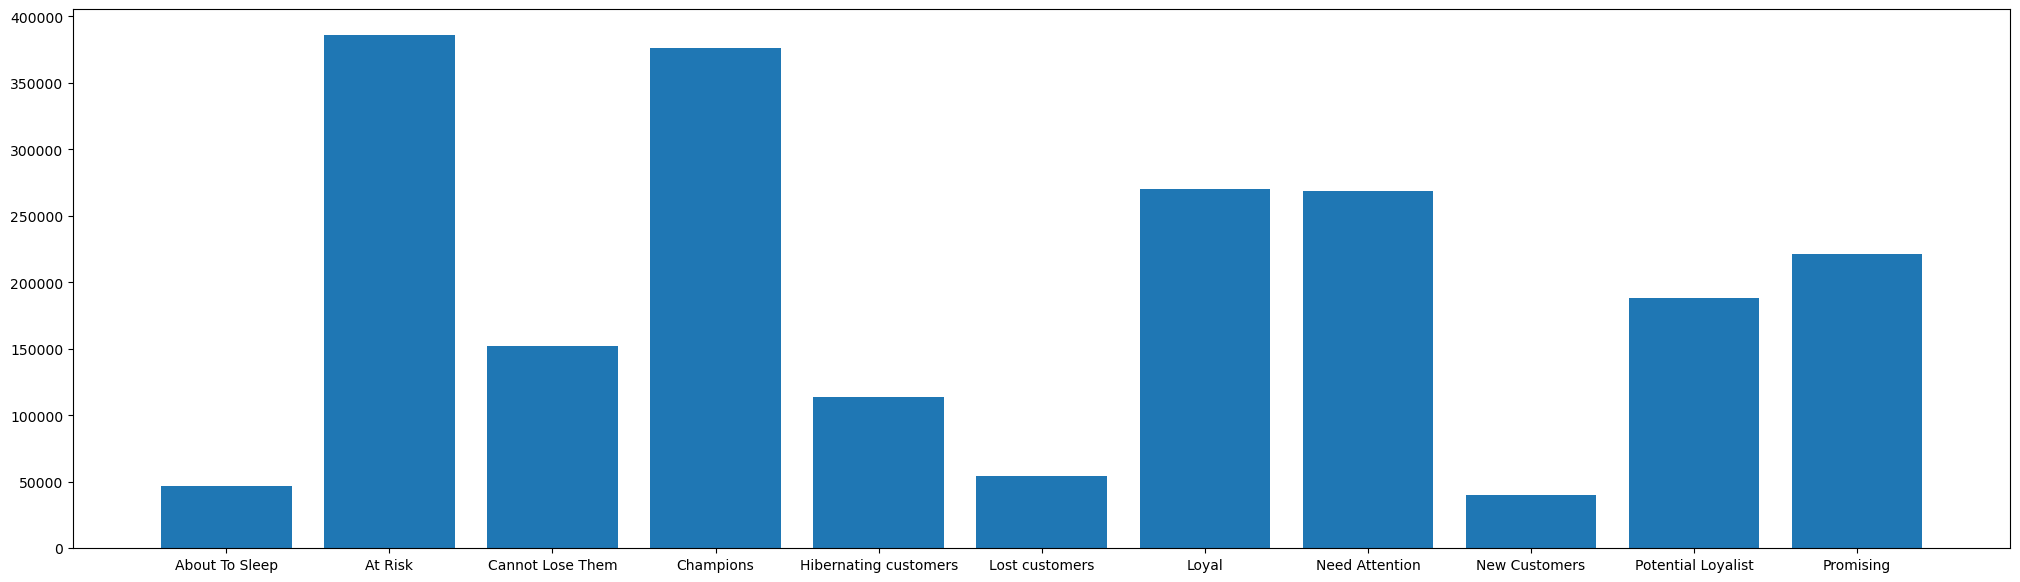

In [34]:
# Sales of each Segment
Segment_Frequency = RFM_Segment.groupby(['Segment'])['Sales'].sum().reset_index()
fig = plt.figure(figsize = (25, 7))
plt.bar(Segment_Frequency['Segment'], Segment_Frequency['Sales'], width = 0.8)
plt.show()

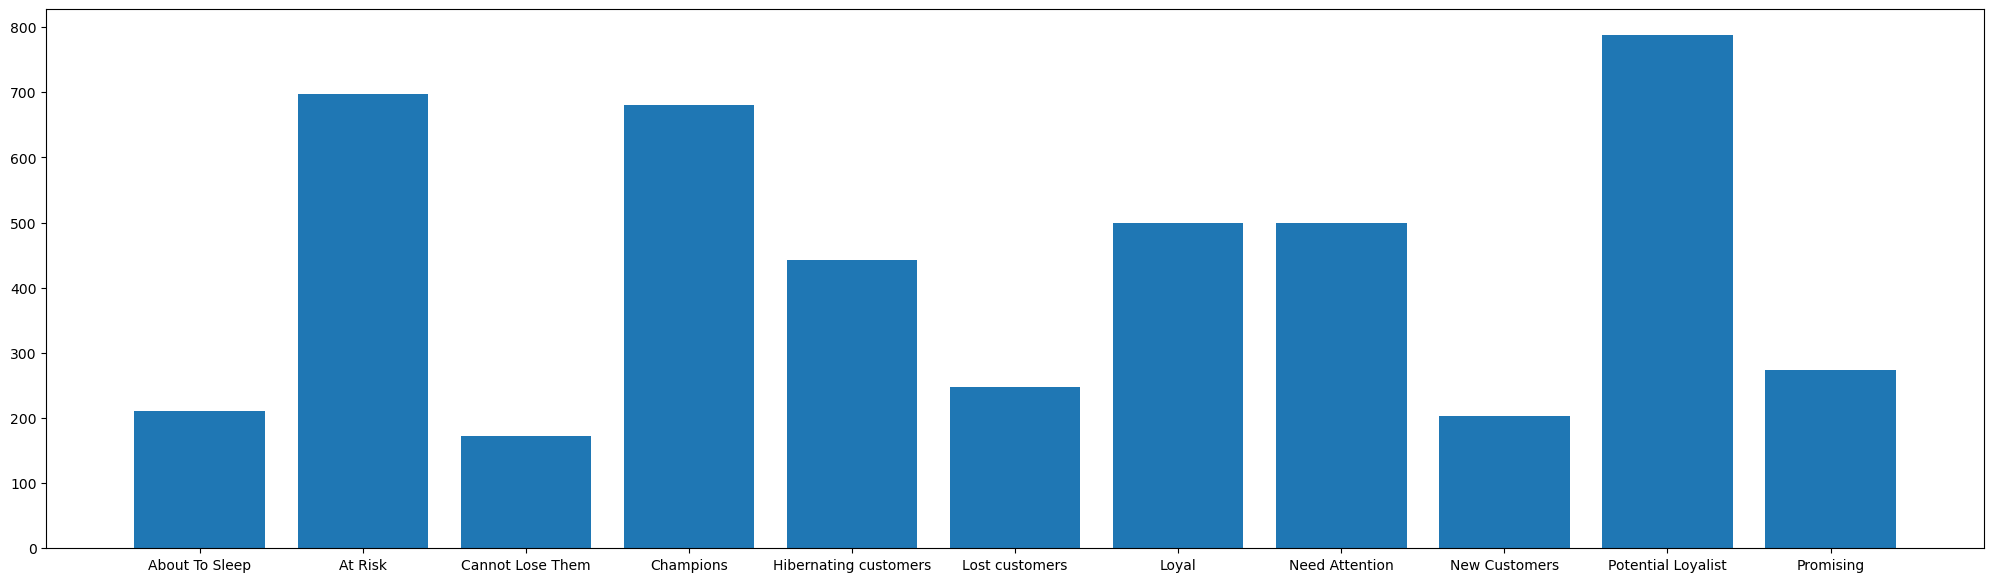

In [35]:
# order quantity of each segment
Segment_Order = RFM_Segment.groupby(['Segment'])['order quantity'].sum().reset_index()
fig = plt.figure(figsize = (25, 7))
plt.bar(Segment_Order['Segment'], Segment_Order['order quantity'], width = 0.8)
plt.show()

### Definition and recommended action for each customer segment:

| Segment | Characteristics | Recommendation |
| --- | --- | --- |
| Champions | Bought recently, buy often and spend the most! | Reward them. Can be early adopters for new products. Will promote your brand. |
| Loyal | Spend good money with us often. Responsive to promotions. | Upsell higher value products. Ask for reviews. Engage them. |
| Potential Loyalist | Recent customers, but spent a good amount and bought more than once. | Offer membership / loyalty program, recommend other products. |
| New customers | Bought most recently, but not often. | Provide on-boarding support, give them early success, start building relationship. |
| Promising | Recent shoppers, but haven’t spent much. | Create brand awareness, offer free trials |
| Need attention | Above average recency, frequency and monetary values. May not have bought very recently though. | Make limited time offers, Recommend based on past purchases. Reactivate them. |
| At risk | Spent big money and purchased often. But l| About to sleep | Below average recency, frequency and monetary values. Will lose them if not reactivated. | Share valuable resources, recommend popular products / renewals at discount, reconnect with them. |
ong time ago. Need to bring them back! | Send personalized emails to reconnect, offer renewals, provide helpful resources. |
| Cannot lose them | Made biggest purchases, and often. But haven’t returned for a long time. | Win them back via renewals or newer products, don’t lose them to competition, talk to them. |
| Hibernating customers | Last purchase was long back, low spenders and low number of orders. | Offer other relevant products and special discounts. Recreate brand value. |
| Lost customers | Lowest recency, frequency and monetary scores. | Revive interest with reach out campaign, ignore otherwise. |